# <center> **Decision trees - Bike Rental Prediction** <centre>

## Introduction

This data was put together by Hadi Fanaee-T at the University of Porto. The file contains 17380 rows of information of the number of bike rentals for a single hour of a single day.
The data can be downloaded from:       
http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset         


**Aim:**
The aim of this to try a number of machine learning algorithms for the prediction of bike rentals given a number of features as an input.       

Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
%load_ext google.colab.data_table

In [2]:
bike_rentals = pd.read_csv('/content/drive/MyDrive/Bike_Rentals/bike_rental_hour.csv')

In [3]:
bike_rentals.shape

(17379, 17)

In [4]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


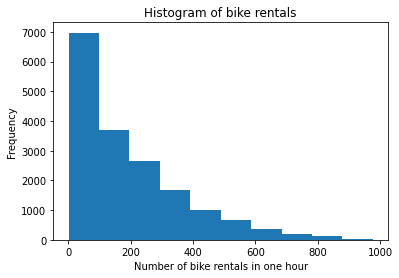

In [5]:
plt.hist(bike_rentals['cnt'])
plt.title('Histogram of bike rentals')
plt.xlabel('Number of bike rentals in one hour')
plt.ylabel('Frequency')
plt.show()

The total number of bike hires in one hour appears to be most often, less than 200 and rarely goes up to just above 800 rentals.

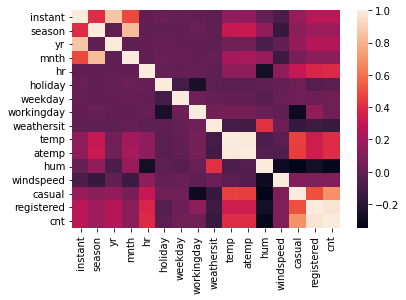

In [6]:
corrmat = bike_rentals.corr()
sns.heatmap(corrmat)

In [7]:
sorted_corrmat = corrmat['cnt'].abs().sort_values(ascending=False)
sorted_corrmat

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

## Calculating features               
We dont want the machine to treat each hour differently so I will group some of the hours together with labels

In [8]:
def assign_label(num):
  if 6 <= num < 12:
    return 1
  if 12 <= num < 18:
    return 2
  if 18 <= num < 24:
    return 3
  if 0 <= num < 6:
    return 0

In [9]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,0
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,0
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,1
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3,1
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8,1
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,1


I would use as the mean squared error metric for evaluating the machine learning algorithm

## Selecting the train and test datasets

In [10]:
proportion = 0.8
train = bike_rentals.sample(frac=proportion, replace=True)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)] # Selecting the opposite of the train dataset

Due to the high correlation with cnt, we will use linear regression. LR is fairly resistant to overfitting.        
Lets ignore the casual and registered columns.

In [11]:
train.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'time_label'],
      dtype='object')

## Starting the machine learning with the linear regression

In [12]:
features = train.columns.drop(['registered', 'casual', 'dteday', 'cnt'])
features

Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'time_label'],
      dtype='object')

In [13]:
target = ['cnt']

In [14]:
lr = LinearRegression()
lr.fit(train[features], train[target])
predictions = lr.predict(test[features])
mse  = mean_squared_error(predictions, test['cnt'])
mse

19410.353235111637

This error result is quite high.       
Lets look at whta we can do with decision trees instead.
## Decision trees

In [15]:
dt = DecisionTreeRegressor(min_samples_leaf=5)
dt.fit(train[features], train[target])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [16]:
predictions = dt.predict(test[features])
mse  = mean_squared_error(predictions, test['cnt'])
mse

2893.53087251583

Here the result is much lower. We must be mindful of overfitting.      
Lets vary the min_samples_leaf argument.

In [17]:
min_samples = ['2', '5', '7', '9', '10', '12']
result = {}
for min in min_samples:
  dt = DecisionTreeRegressor(min_samples_leaf=int(min))
  dt.fit(train[features], train[target])
  predictions = dt.predict(test[features])
  mse  = mean_squared_error(predictions, test[target])
  result[min] = mse
result

{'10': 2902.9856384679206,
 '12': 2942.0357455354383,
 '2': 3450.2367072562943,
 '5': 2894.3550090820577,
 '7': 2870.622818467271,
 '9': 2921.3613757282187}

I will use the result of min_samples_leaf=5       
## Using the random forest approach        
This approach should be much more accurate than the linear regression approach

In [36]:
rf = RandomForestRegressor(min_samples_leaf=5)
rf.fit(train[features], train[target].values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [19]:
predictions = dt.predict(test[features])
mse  = mean_squared_error(predictions, test[target])
mse

2942.0357455354383

## Testing various feature columns for improvement

In [20]:
# These are the current features
features

Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'time_label'],
      dtype='object')

In [31]:
def RandomForest(features, min_samples_leaf):
  rf = RandomForestRegressor(min_samples_leaf=5)
  rf.fit(train[features], train[target].values.ravel())
  predictions = rf.predict(test[features])
  mse  = mean_squared_error(predictions, test[target])
  return mse

In [22]:
# Old features:
old_features = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']

In [23]:
old_features

['instant',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

In [25]:
new_features = {}
for c, i in enumerate(old_features):
  temp = old_features.copy()
  del temp[c]
  # temp.remove(temp[c])
  new_features[c] = temp
new_features[0]

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

In [32]:
RandomForest(new_features[0], 5)

2252.449876663216

This result is much better. Lets explore further for the impact that different columns may have.      

In [34]:
from itertools import chain
results = {}

for c in range(14):
  results[c] = RandomForest(new_features[c], 5)

results

{0: 2223.637930415758,
 1: 2070.6901194875963,
 2: 2076.855962115382,
 3: 2095.823693217502,
 4: 12226.891922610333,
 5: 2085.1565564176085,
 6: 2275.3357147996894,
 7: 2421.153383035695,
 8: 2196.490636799252,
 9: 2064.8817956929847,
 10: 2102.599017918783,
 11: 2230.3591414198545,
 12: 2046.3158684544246,
 13: 2076.2619932373523}

Interpretation of results.       
Removal of:      
1: 'instant',        
2:  'season',        
3:  'yr',        
4:  'mnth',                
5:  'hr',        
6:  'holiday',        
7:  'weekday',                
8:  'workingday',        
9:  'weathersit',                
10: 'temp',        
11: 'atemp',        
12: 'hum',        
13: 'windspeed',        
14: 'time_label'        


Here we can see through eliminating one of the columns at a time, we can improve the mean squared error. This can show the dependance of the results in the features that are passed in and give some insight into what may be possibly causing overfitting or a heavily important column. Eg trial number 4 above. It can also highlight some columns that could be further removed.
## Summary          
     
Here I was able to use linear regression, a decision forest and random forest to predict total number of bike rentals given a number of features that can be passed. It was the random forest that gave the best results.          
     
Thanks again for reading!          
Have a great week!         
Best regards,         
Bill  
